# Домашнее задане №2, Бутурлакина Д.Ю., РИ-400034

### Импорт нужных библиотек

In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.tsa.api as smt
import statsmodels.api as sm

from itertools import product
from tqdm import tqdm_notebook

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_squared_log_error

%matplotlib inline

Чтение данных из CSV-файла в DataFrame

In [4]:
df = pd.read_csv('rainfall.csv', index_col=['date'], parse_dates=['date'])
df

,mean_rainfall
date,
1990-01-01,1.613
1990-01-11,1.557
1990-01-21,2.219
1990-02-01,4.788
1990-02-11,6.510
...,...
2019-11-11,6.737
2019-11-21,5.216
2019-12-01,2.022


Группировка данных по месяцам, вычисление среднего значения, удаление с отсутствующими значениями

In [5]:
df = df.resample('M').mean().dropna()

In [6]:
df

,mean_rainfall
date,
1990-01-31,1.796333
1990-02-28,5.270333
1990-03-31,9.169667
1990-04-30,16.180333
1990-05-31,78.126333
...,...
2019-08-31,174.259000
2019-09-30,83.920000
2019-10-31,44.260333


Вывод информации

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 360 entries, 1990-01-31 to 2019-12-31
Freq: M
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   mean_rainfall  360 non-null    float64
dtypes: float64(1)
memory usage: 5.6 KB


### Построение графика среднего уровня осадков

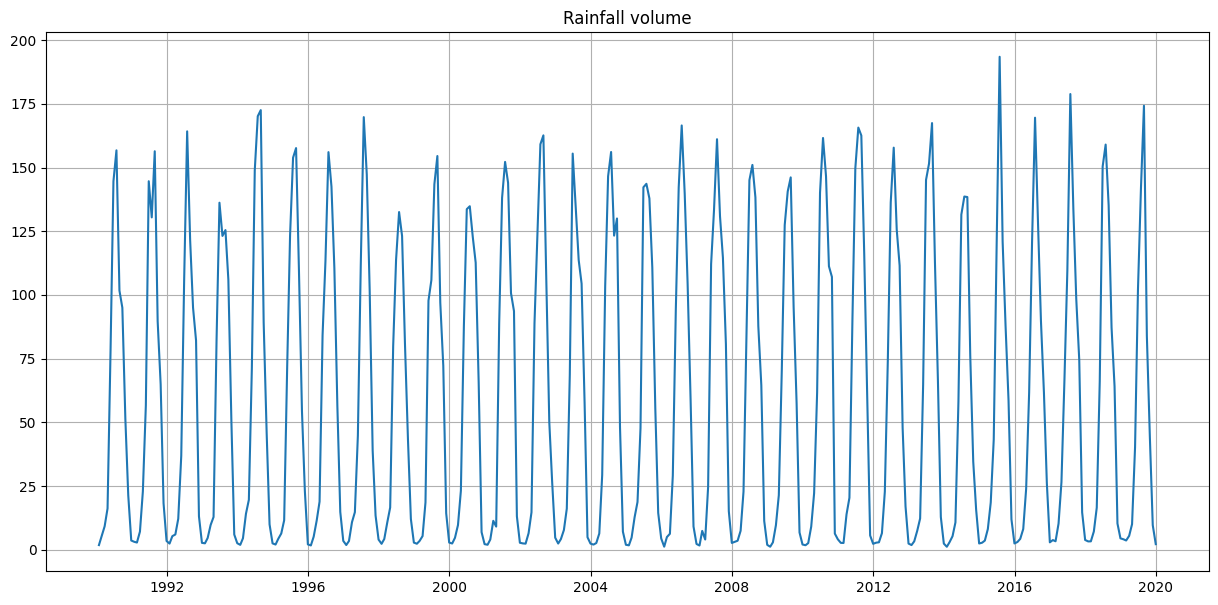

In [8]:
plt.figure(figsize=(15, 7))
plt.plot(df.mean_rainfall)
plt.title('Rainfall volume')
plt.grid(True)
plt.show()

 1. Тренд не наблюдается, среднее значение приблизительно на одном уровне
 2. Наблюдается сезонность ряда, так как в начале года - увеличение осадков, в середине года - максимальное значение осадков, в конце года - уменьшение осадков
 3. Ряд не является стационарным

### Разделение выборки

In [9]:
def timeseries_train_test_split(df, test_size):

    test_index = int(len(df)*(1-test_size))

    df_train = df.iloc[:test_index]
    df_test = df.iloc[test_index:]

    return df_train, df_test

Разделение временных рядов

In [10]:
df_train, df_test = timeseries_train_test_split(df, test_size=0.3)

## Бейзлайн

### Возвращение скользящего среднего

In [11]:
def moving_average(series, n):
    return np.average(series[-n:])

moving_average(df_train, 3) 

74.88077777777778

Вывод первой строки

In [12]:
df_test.head(1)

,mean_rainfall
date,
2010-12-31,4.079667


### Построение графика скользящего среднего

In [13]:
def plotMovingAverage(series, window):

    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "r", label="Rolling mean trend")

    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

Вызов функции для построения графика

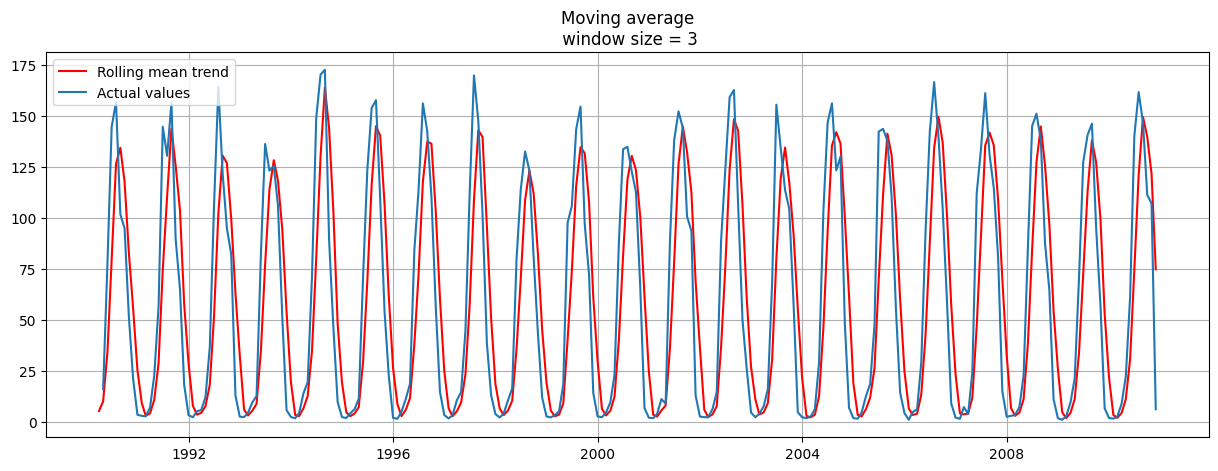

In [14]:
plotMovingAverage(df_train, 3)

### Замеры качества работы модели

Оценка точности прогнозирования скользящего среднего по сравнению с фактическими данными

In [15]:
mean_absolute_error([moving_average(df_train, 3)], df_test.head(1))

70.80111111111111

## Статистическая модель

### Оценка стационарности ряда

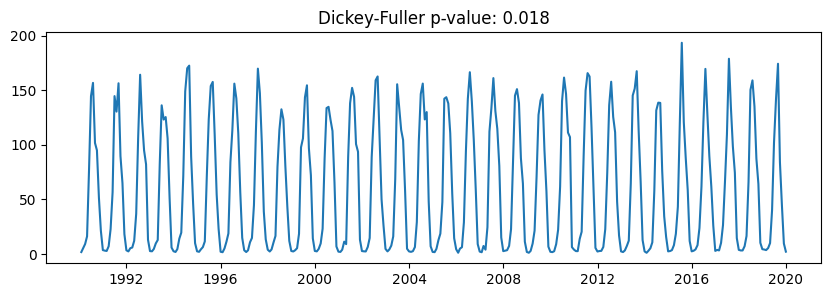

In [16]:
plt.figure(figsize=(10, 3))
plt.plot(df)
plt.title("Dickey-Fuller p-value: {}".format(round(sm.tsa.stattools.adfuller(df_train)[1], 3)))
plt.show()

Ряд является стационарным

### Построение ACF и PACF

In [17]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):

    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

Построение графика

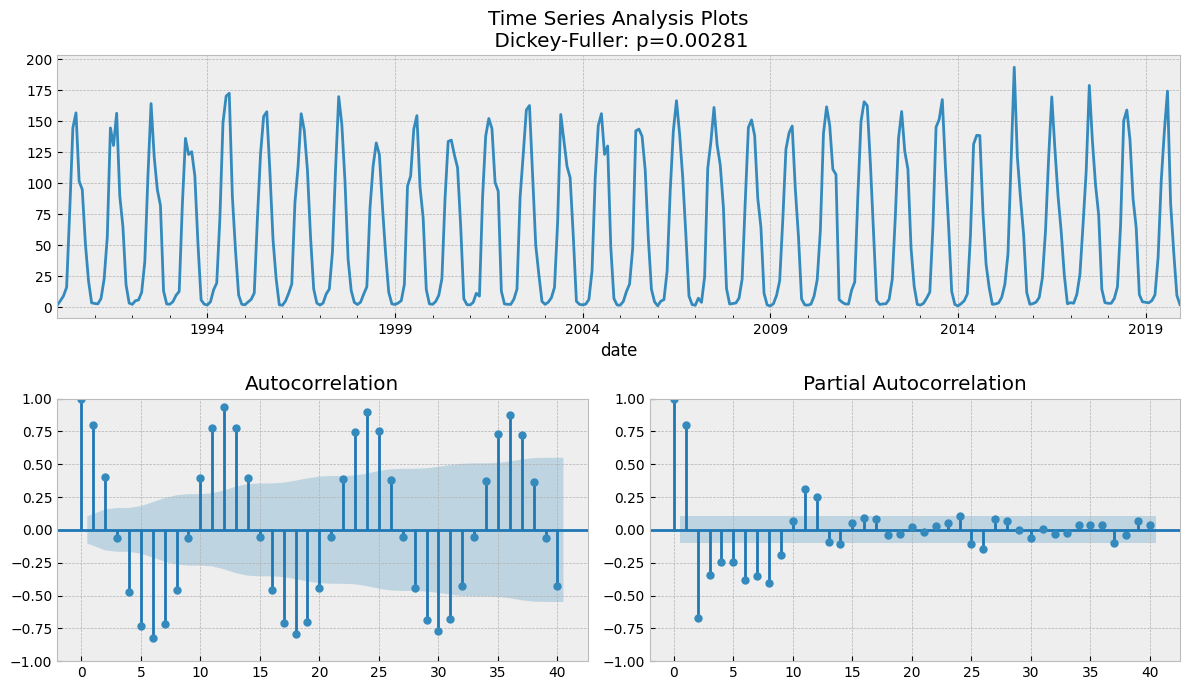

In [18]:
tsplot(df.mean_rainfall, lags=40)

Сезонность нашего временного ряда составляет 1 год

### Сезонное дифференцирование с проверкой на стационарность и визуализацией

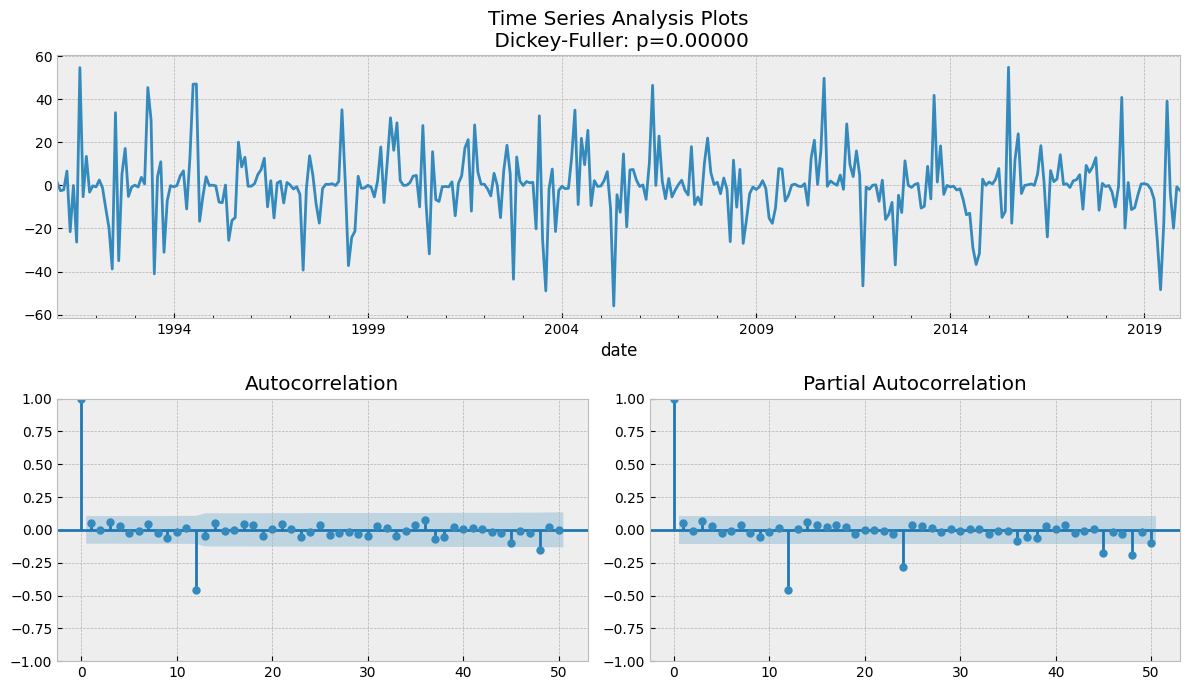

In [19]:
df_diff = df.mean_rainfall - df.mean_rainfall.shift(12)
tsplot(df_diff[12:], lags=50)

Наш ряд по-прежнему является стационарным, после дифференцирования 12-ый лаг имеет большую корреляцию, поэтому проведено еще одно дифференцирование.

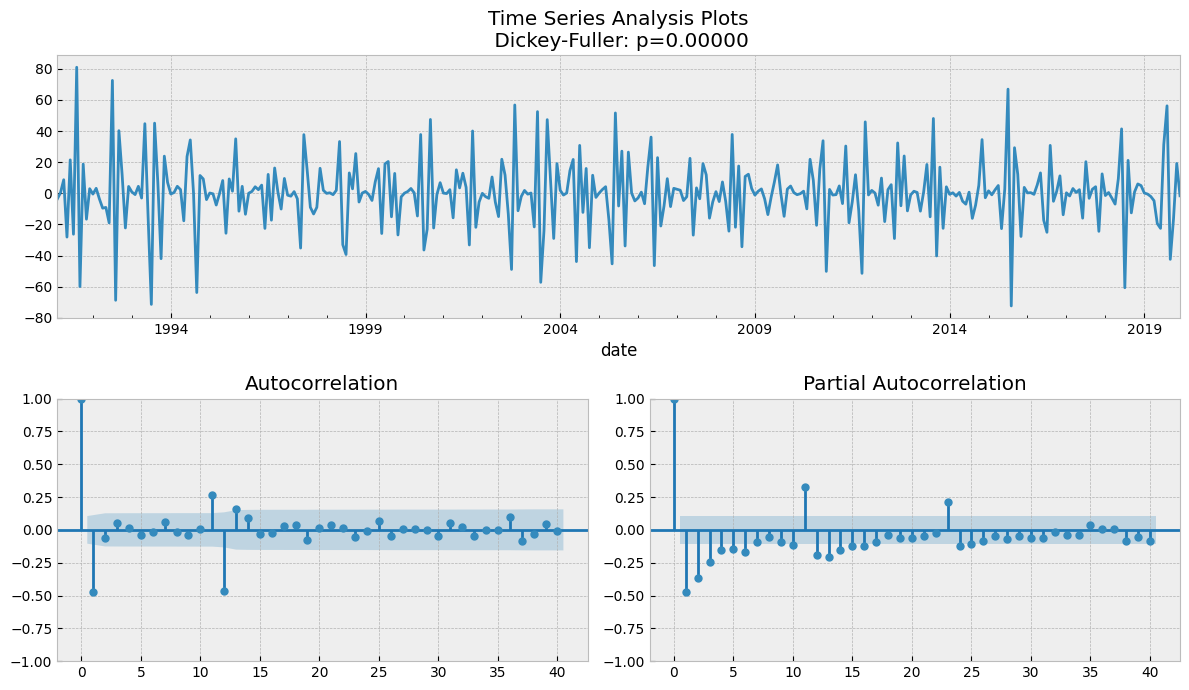

In [20]:
df_diff = df_diff - df_diff.shift(1)
tsplot(df_diff[12+1:], lags=40)

In [21]:
df_diff = df.mean_rainfall - df.mean_rainfall.shift(12)

### Обучение модели SARIMA

In [22]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC

        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order
        s - length of season
    """

    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model = sm.tsa.statespace.SARIMAX(df.mean_rainfall, order=(param[0], d, param[1]),
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)

    return result_table

Параметры модели:

d = 0 - обычное дифференцирование не проводилось

D = 1 - 1 раз проводилось сезонное дифференцирование

s = 12 - период ряда равен 12-ти измерениям

p = 2 или 3 - из наблюдений PACF

q = 2 или 3 - из наблюдений ACF

P = 1 или 2 - из наблюдений PACF

Q = 2 - из наблюдений ACF

In [23]:
ps = range(2, 4)
d=0
qs = range(2, 4)
Ps = range(0, 2)
D=1
Qs = range(2, 3)
s = 12

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

8

Измерение и отображение времени, затраченного на выполнение определенной ячейки кода, оптимизация модели SARIMA с заданными параметрами

In [24]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)

  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\darja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\darja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\darja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\darja\AppData\Local\Packages

CPU times: total: 10.3 s
Wall time: 37.4 s


Отображение верхних строк таблицы

In [25]:
result_table.head()

,parameters,aic
0,"(3, 3, 1, 2)",2744.639949
1,"(3, 3, 0, 2)",2744.823934
2,"(3, 2, 1, 2)",2745.637837
3,"(2, 3, 1, 2)",2746.937857
4,"(2, 2, 1, 2)",2749.567392


Поиск оптимальных параметров модели SARIMА и вывод результатов анализа

In [26]:
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(df_train, order=(p, d, q),
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

C:\Users\darja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                        SARIMAX Results                                        
Dep. Variable:                           mean_rainfall   No. Observations:                  251
Model:             SARIMAX(3, 0, 3)x(1, 1, [1, 2], 12)   Log Likelihood                -939.369
Date:                                 Sun, 03 Mar 2024   AIC                           1898.739
Time:                                         16:49:15   BIC                           1933.503
Sample:                                     01-31-1990   HQIC                          1912.748
                                          - 11-30-2010                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4888      0.977      0.500      0.617      -1.427       2

Построение графика сравнения прогнозных значений модели SARIMA и фактических значений временного ряда

In [27]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plotSARIMA(series, model, n_steps):

    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN

    # forecasting on n_steps forward
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error1 = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])
    error2 = mean_absolute_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title(f"Mean Absolute Percentage Error: {round(error1, 2)}% (MAE: {round(error2, 2)})")
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True)

In [28]:
plotSARIMA(df_train, best_model, 24)

AttributeError: 'Series' object has no attribute 'append'

Средняя доля абсолютных ошибок составляет 30%, что кажется немалым, однако средняя абсолютная ошибка составляет 8 у. е. осадков, что в разы лучше по сравнению с бейзлайном.

## Классическая модель

### Создание признаков

Создание нового датафрейма

In [29]:
data = pd.DataFrame(df.mean_rainfall.copy())
data.columns = ["y"]

36 признаков под лаги одного полного цикла

In [30]:
for i in range(1, 37):
    data["lag_{}".format(i)] = data.y.shift(i)

Признаки дня и месяца

In [31]:
data['day'] = data.index.day
data['month'] = data.index.month
#data['year'] = data.index.year

Визуализация признаков

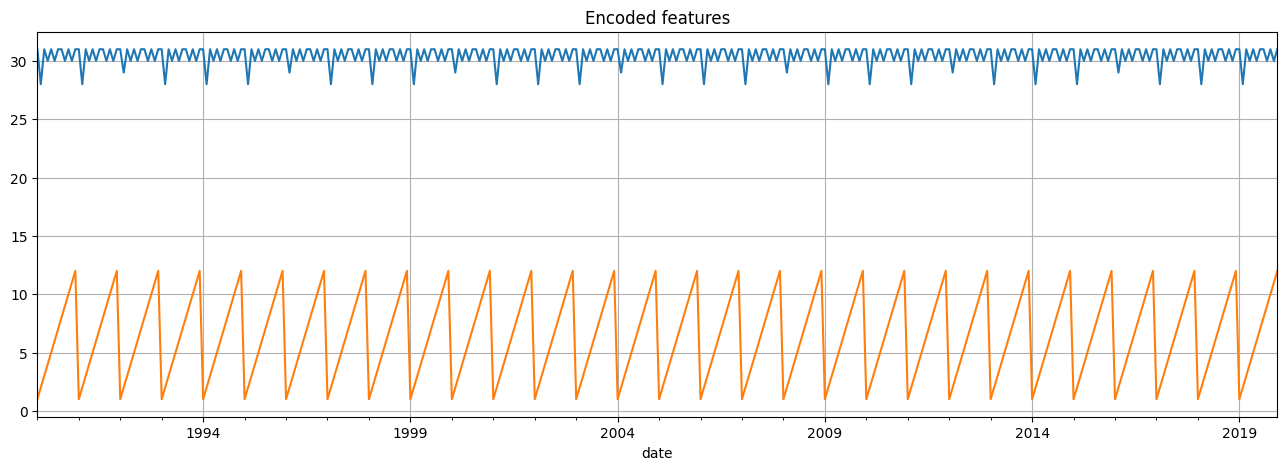

In [53]:
plt.figure(figsize=(16, 5))
plt.title("Encoded features")
data.day.plot()
data.month.plot()
#data.year.plot()
plt.grid(True)

### Обучение модели

In [33]:
def timeseries_train_test_split(X, y, test_size):

    test_index = int(len(X)*(1-test_size))

    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]

    return X_train, X_test, y_train, y_test

Обучающие и тестовые наборы данных для признаков и целевой переменной

In [34]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

Визуализировать результатов прогноза модели и оценка ошибки моделирования

In [35]:
def plotModelResults(model, X_train=X_train, X_test=X_test):

    prediction = model.predict(X_test)

    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)

    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True)

Импорт модели

In [36]:
from sklearn.ensemble import RandomForestRegressor

Наилучший результат

In [37]:
regr = RandomForestRegressor(max_depth=6, random_state=42)
regr.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, random_state=42)

### Визуализация результатов

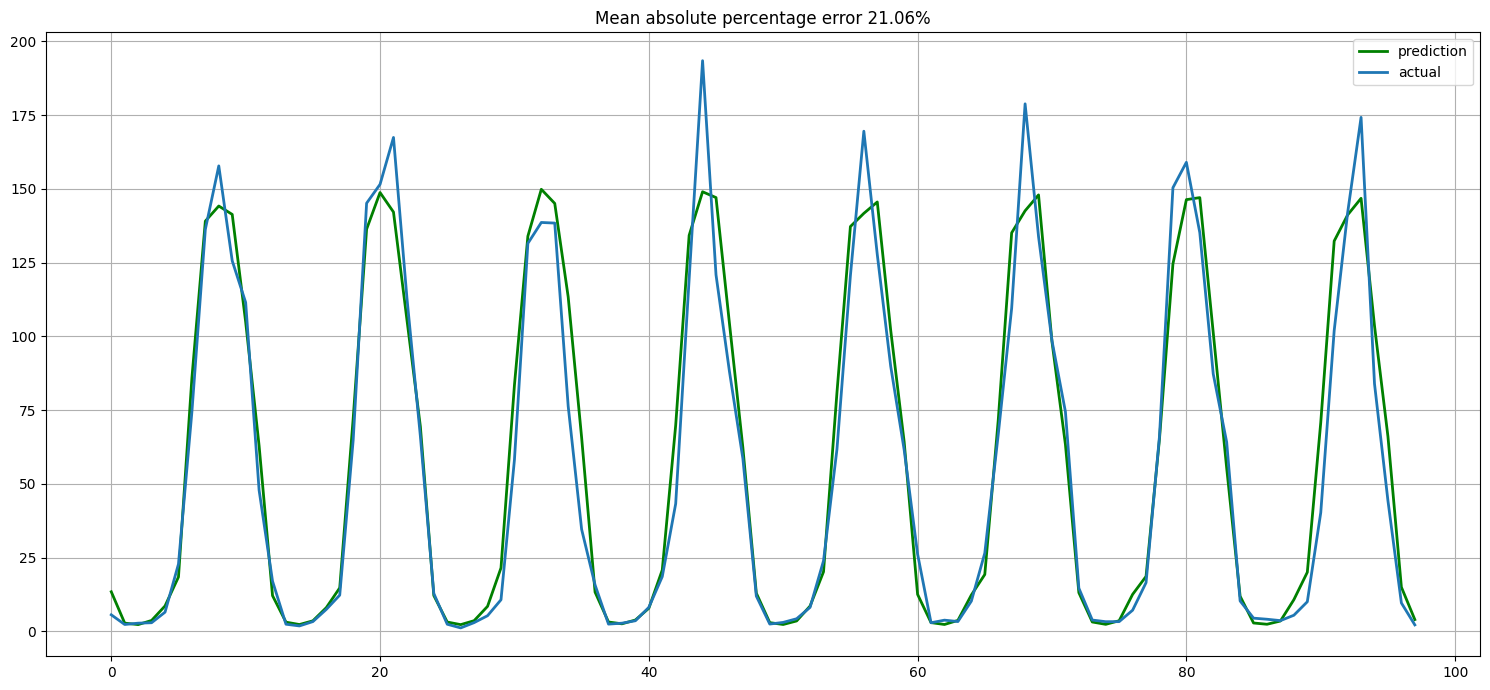

In [38]:
plotModelResults(regr, X_train=X_train, X_test=X_test)

Средняя ошибка модели составляет 21%, но ошибочность модели на 10% меньше по сравнению с моделью SARIMA.

## Интерпретация

### Permutation importance

Захват выводы и ошибок, установка или обновление версий библиотек numpy, shap и lime

In [39]:
%%capture
!pip install -U numpy==1.23.1 shap lime

Импортирование модулей и функций из различных библиотек 

In [42]:
from sklearn.inspection import permutation_importance
import shap
from lime import lime_tabular

Построение графика

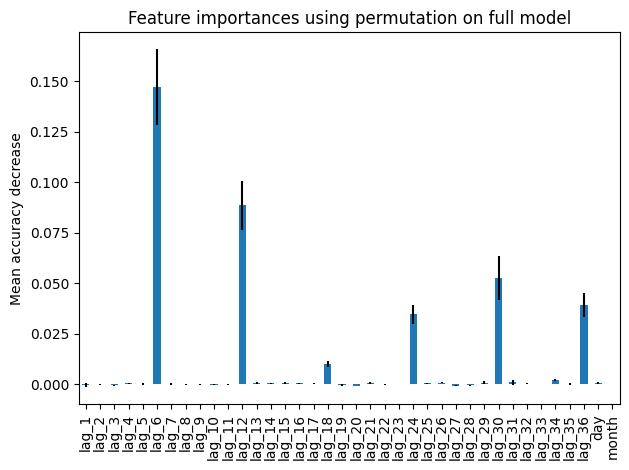

In [43]:
importances = permutation_importance(regr, X_test, y_test, n_repeats=10, random_state=2023, n_jobs=2)
forest_importances = pd.Series(importances.importances_mean, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=importances.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

### LIME

In [44]:
explainer = lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns,
    class_names=['rings'],
    verbose=True,
    mode='regression',
)
i = 33
exp = explainer.explain_instance(X_test.iloc[i].values, regr.predict, num_features=5)

Intercept 40.05660347158667
Prediction_local [127.75139061]
Right: 145.07163060270784


Отображение интерпретации объекта

In [45]:
exp.show_in_notebook(show_table=True)

Возвращение списка функций

In [46]:
exp.as_list()

[('lag_6 <= 4.99', 29.075161981267055),
 ('lag_12 > 112.52', 19.43422488790107),
 ('lag_30 <= 5.14', 13.78688717530408),
 ('lag_36 > 112.01', 13.368822527644026),
 ('lag_24 > 112.52', 12.029690562329224)]

### SHAP - локальная интерпретация

In [47]:
explainer = shap.TreeExplainer(regr)

Визуализация

In [48]:
choosen_instance = X_test.iloc[[33]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], choosen_instance)

Визуализация

In [49]:
choosen_instance = X_test.iloc[[27]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], choosen_instance)

### SHAP - глобальная интерпретация

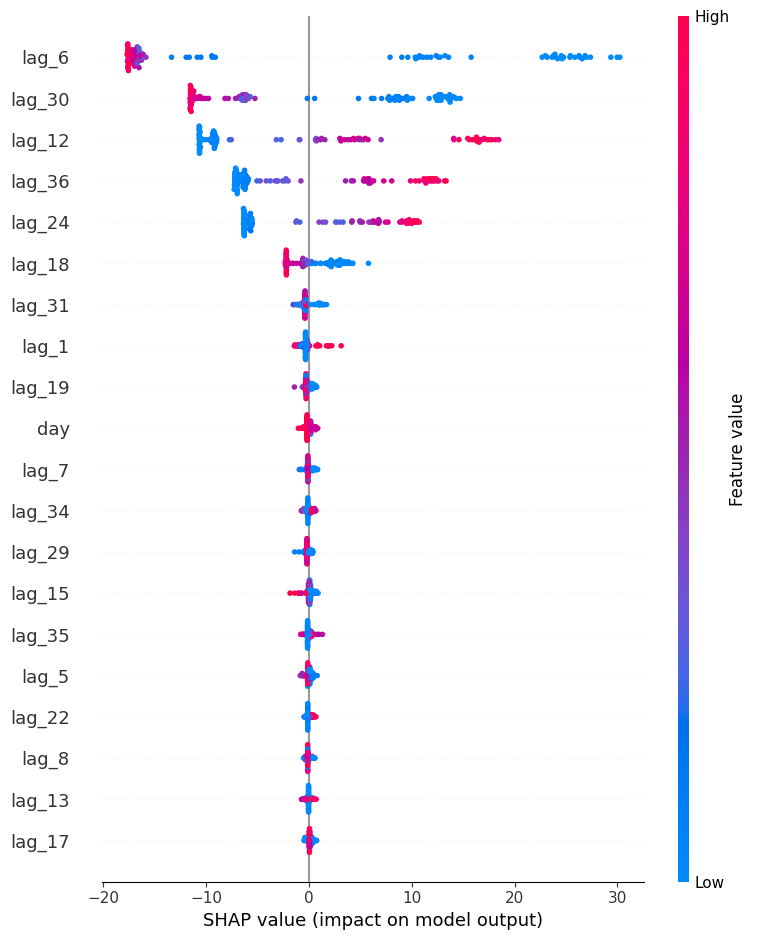

In [50]:
shap_values = explainer.shap_values(X_train.iloc[:100])
shap.summary_plot(shap_values, X_train.iloc[:100])

Самые значимые лаги для анализа: 6, 12, 18, 24, 30, 36.